<h1 align="center">LSTM Time Series Forecasting Training Notebook</h1>

This notebook demonstrates the process of training various LSTM models for time series forecasting using the components from the LSTM_Dockerized project. It covers data preparation, model creation, training, and evaluation.

# 1. Introduction

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) architecture designed to model temporal sequences and their long-range dependencies more accurately than conventional RNNs. This notebook walks through the complete workflow for training LSTM models for time series forecasting, using the components from the LSTM_Dockerized project.

We'll cover:
- Data loading and preprocessing
- Creating sequences for LSTM input
- Building and configuring different LSTM architectures
- Training and evaluating the models
- Visualizing results and model performance

# 2. Environment Setup

In [3]:
# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import json
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import sys

# Add the parent directory to the Python path to find the utils module
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure plot style
plt.style.use('ggplot')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)

# Make TensorFlow less verbose
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Check if GPU is available
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print(f"GPU Devices: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.15.0
GPU Available: False
GPU Devices: []


# 3. Data Loading and Exploration

Data shape: (1000, 1)
               value
2020-01-01  0.049671
2020-01-02  0.206206
2020-01-03  0.386099
2020-01-04  0.426142
2020-01-05  0.134685


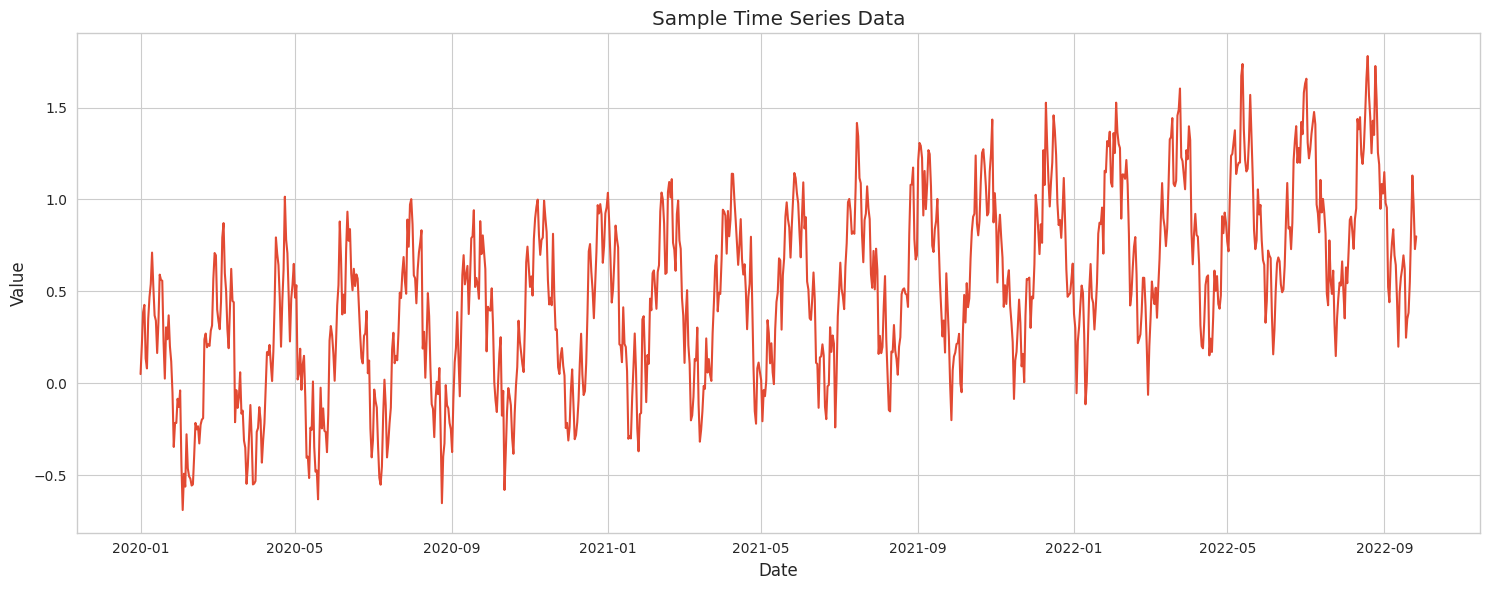

Is stationary: False
p-value: 0.1957
Test statistic: -2.2296


In [4]:
# Import custom data preprocessing utilities
from utils.preprocessing import normalize_data, create_sequences, train_val_test_split, detect_stationarity

# Load sample time series data (e.g., stock prices)
# For this example, let's use a synthetic dataset. In practice, you would load your actual data.
def generate_sample_data(n_samples=1000):
    """Generate a synthetic time series with trend, seasonality, and noise."""
    time = np.arange(n_samples)
    # Trend component
    trend = 0.001 * time
    # Seasonal component (multiple seasonal patterns)
    season1 = 0.5 * np.sin(2 * np.pi * time / 50)  # 50-day cycle
    season2 = 0.2 * np.sin(2 * np.pi * time / 7)   # Weekly cycle 
    # Random noise
    noise = 0.1 * np.random.randn(n_samples)
    # Combine components
    data = trend + season1 + season2 + noise
    return pd.DataFrame({'value': data})

# Generate and plot sample data
data = generate_sample_data(1000)
data.index = pd.date_range(start='2020-01-01', periods=len(data), freq='D')
print(f"Data shape: {data.shape}")
print(data.head())

# Plot the time series
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['value'])
plt.title('Sample Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# Check for stationarity
is_stationary, pvalue, test_statistic = detect_stationarity(data['value'], test='adfuller')
print(f"Is stationary: {is_stationary}")
print(f"p-value: {pvalue:.4f}")
print(f"Test statistic: {test_statistic:.4f}")

# 4. Data Preprocessing

In [5]:
# Normalize the data
normalized_data, scaler = normalize_data(data, method='minmax')
print("Normalized data head:")
print(normalized_data.head())

# Create sequences for LSTM input
seq_length = 30  # Look back 30 time steps
horizon = 1      # Predict 1 step ahead

X, y = create_sequences(normalized_data, seq_length=seq_length, horizon=horizon)
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Split data into training, validation, and test sets
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X, y, val_size=0.2, test_size=0.1, shuffle=False
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Normalized data head:
               value
2020-01-01  0.299434
2020-01-02  0.362810
2020-01-03  0.435642
2020-01-04  0.451854
2020-01-05  0.333853
X shape: (970, 30, 1), y shape: (970, 1, 1)
Training set: (679, 30, 1), (679, 1, 1)
Validation set: (194, 30, 1), (194, 1, 1)
Test set: (97, 30, 1), (97, 1, 1)


# 5. Model Creation

In [6]:
# Import model creation utilities
from models.model_factory import create_model, create_model_from_config
from models.training.trainer import train_model
from models.evaluation.evaluator import evaluate_model
from models.training.callbacks import create_callbacks

# Define a model configuration
model_config = {
    "architecture": "vanilla_lstm",
    "input_shape": (seq_length, 1),
    "lstm_units": 50,
    "dropout_rate": 0.2,
    "output_units": 1,
    "activation": "linear",
    "compile": {
        "optimizer": "adam",
        "learning_rate": 0.001,
        "loss": "mse",
        "metrics": ["mae"]
    }
}

# Create the model
model = create_model_from_config(model_config)

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 6. Model Training

Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 0.1198 - mae: 0.2800
Epoch 1: val_loss improved from inf to 0.02725, saving model to /app/notebooks/models/checkpoints/best_model.h5


/usr/local/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 5s 80ms/step - loss: 0.1198 - mae: 0.2800 - val_loss: 0.0272 - val_mae: 0.1374 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 0.0273 - mae: 0.1372
Epoch 2: val_loss improved from 0.02725 to 0.02679, saving model to /app/notebooks/models/checkpoints/best_model.h5
22/22 [==============================] - 1s 38ms/step - loss: 0.0273 - mae: 0.1372 - val_loss: 0.0268 - val_mae: 0.1337 - lr: 0.0010
Epoch 3/100
20/22 [==========================>...] - ETA: 0s - loss: 0.0209 - mae: 0.1195
Epoch 3: val_loss improved from 0.02679 to 0.02630, saving model to /app/notebooks/models/checkpoints/best_model.h5
22/22 [==============================] - 1s 36ms/step - loss: 0.0206 - mae: 0.1185 - val_loss: 0.0263 - val_mae: 0.1340 - lr: 0.0010
Epoch 4/100
22/22 [==============================] - ETA: 0s - loss: 0.0183 - mae: 0.1110
Epoch 4: val_loss improved from 0.02630 to 0.01690, saving model to /app/notebooks/models/checkpoin

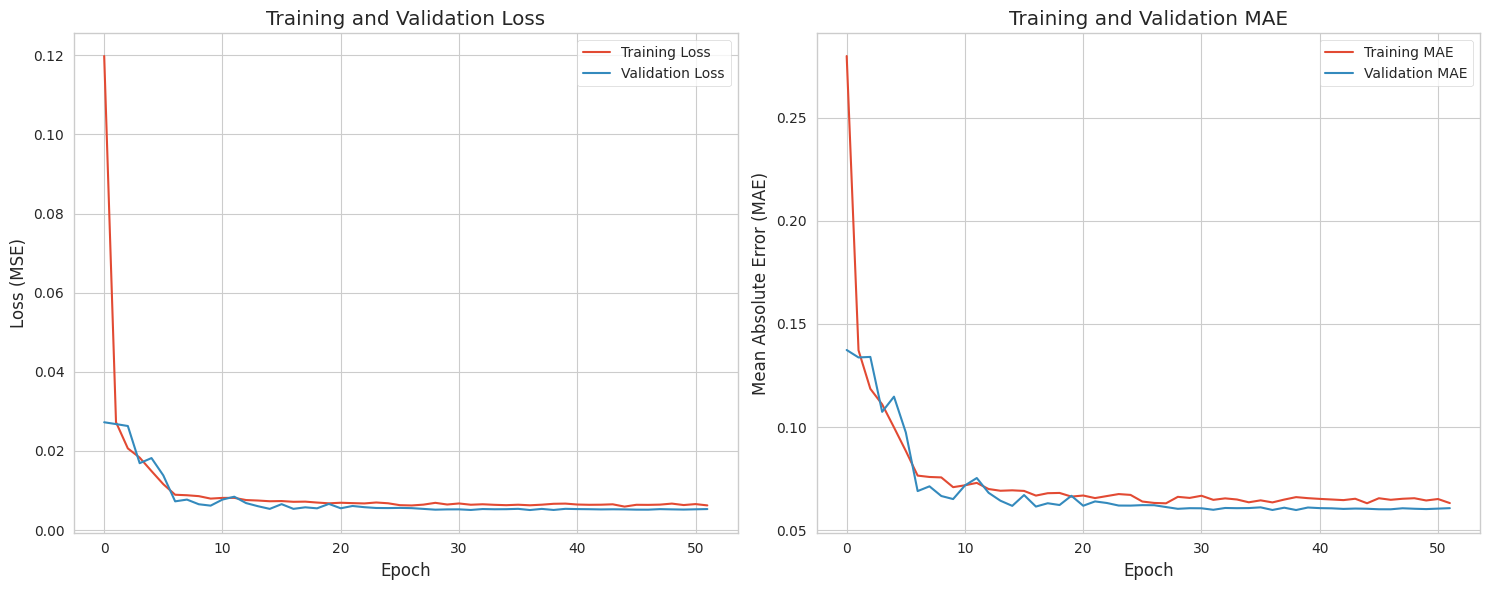

In [7]:
# Training parameters
epochs = 100
batch_size = 32
patience = 15

# Create directory for model checkpoints
checkpoint_dir = os.path.join(os.getcwd(), 'models', 'checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'best_model.h5')

# Train the model
history = train_model(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val, 
    y_val=y_val,
    epochs=epochs,
    batch_size=batch_size,
    early_stopping=True,
    patience=patience,
    checkpoint_path=checkpoint_path,
    tensorboard=True,
    log_dir='logs',
    save_best_model=True
)

# Plot training history
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.title('Training and Validation MAE')

plt.tight_layout()
plt.show()

# 7. Model Evaluation

4/4 [==============================] - 0s 10ms/step
y_test shape: (97, 1, 1)
y_pred shape: (97, 1)
4/4 [==============================] - 0s 8ms/step
Evaluation Metrics on Test Data:
mse: 0.0280
rmse: 0.1672
mae: 0.1451
mape: 20.9667
smape: 19.1212
directional_accuracy: nan
theil_u: 0.9153


/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


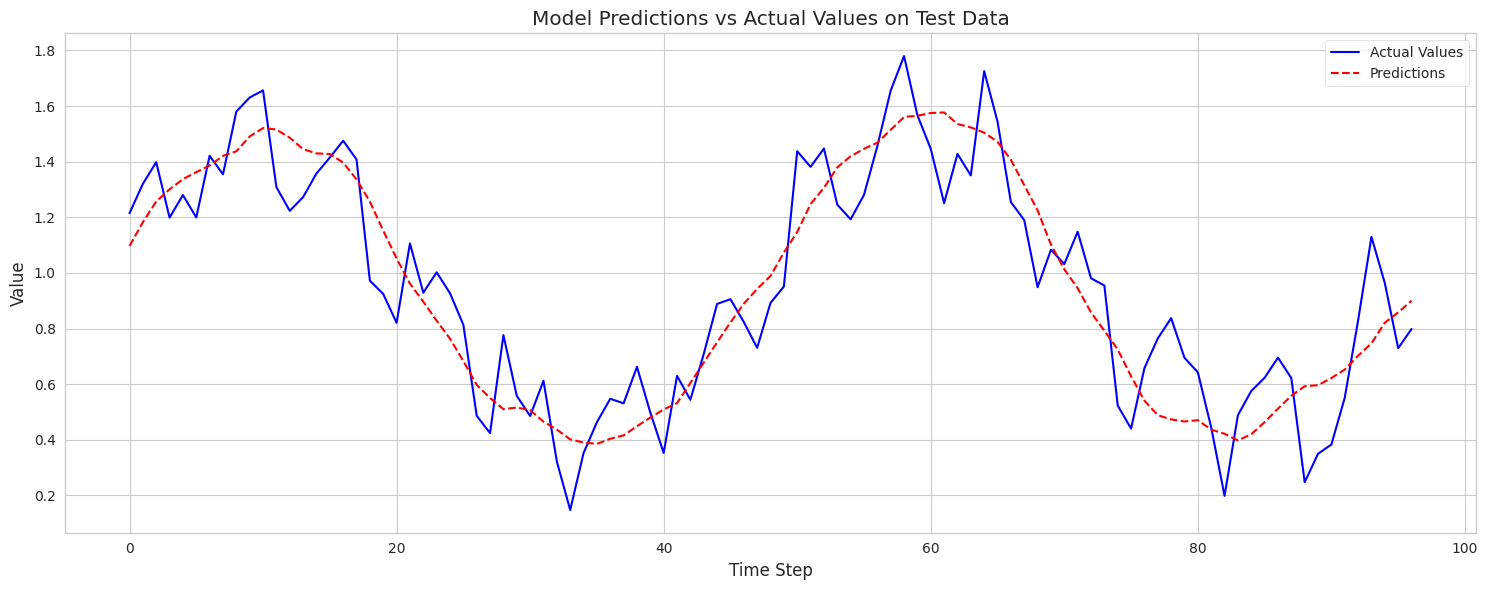

In [9]:
# Evaluate the model on test data
from utils.metrics import calculate_all_metrics

# Generate predictions on the test set
y_pred = model.predict(X_test)

# First, reshape the data for inverse transformation
# Check the shapes of y_test and y_pred
print(f"y_test shape: {y_test.shape}")
print(f"y_pred shape: {y_pred.shape}")

# Ensure y_test and y_pred are 2D for inverse_transform and metrics calculation
if len(y_test.shape) > 2:
    y_test_reshaped = y_test.reshape(y_test.shape[0], -1)
else:
    y_test_reshaped = y_test.reshape(-1, 1) if len(y_test.shape) == 1 else y_test

if len(y_pred.shape) > 2:
    y_pred_reshaped = y_pred.reshape(y_pred.shape[0], -1)
else:
    y_pred_reshaped = y_pred.reshape(-1, 1) if len(y_pred.shape) == 1 else y_pred

# Inverse transform to get back to original scale
y_test_inv = scaler.inverse_transform(y_test_reshaped)
y_pred_inv = scaler.inverse_transform(y_pred_reshaped)

# Ensure data is 2D for metrics calculation
if len(y_test_inv.shape) > 2:
    y_test_inv = y_test_inv.reshape(y_test_inv.shape[0], -1)
if len(y_pred_inv.shape) > 2:
    y_pred_inv = y_pred_inv.reshape(y_pred_inv.shape[0], -1)

# Calculate metrics manually or use your metrics function with reshaped data
metrics = {}
try:
    metrics = evaluate_model(model, X_test, y_test, scaler)
except ValueError:
    # If the evaluator still fails, calculate metrics directly
    metrics = calculate_all_metrics(y_test_inv, y_pred_inv)

# Print evaluation results
print("Evaluation Metrics on Test Data:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot predictions vs actual values
plt.figure(figsize=(15, 6))
plt.plot(y_test_inv, label='Actual Values', color='blue')
plt.plot(y_pred_inv, label='Predictions', color='red', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Model Predictions vs Actual Values on Test Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Trying Different LSTM Architectures


--------------------------------------------------
Training vanilla_lstm architecture
--------------------------------------------------
Training vanilla_lstm model...

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Training completed in 34.68 seconds
Total epochs: 50
Best validation loss: 0.004598 (epoch 50)
4/4 [==============================] - 1s 11ms/step
Calculated metrics for vanilla_lstm: {'mse': 0.05277359550931896, 'mae': 0.18721761178533342, 'rmse': 0.22972504327852233}
Test metrics for vanilla_lstm:
  mse: 0.0528
  mae: 0.1872
  rmse: 0.2297

--------------------------------------------------
Training stacked_lstm architecture
--------------------------------------------------
Training stacked_lstm model...

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 40: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoc

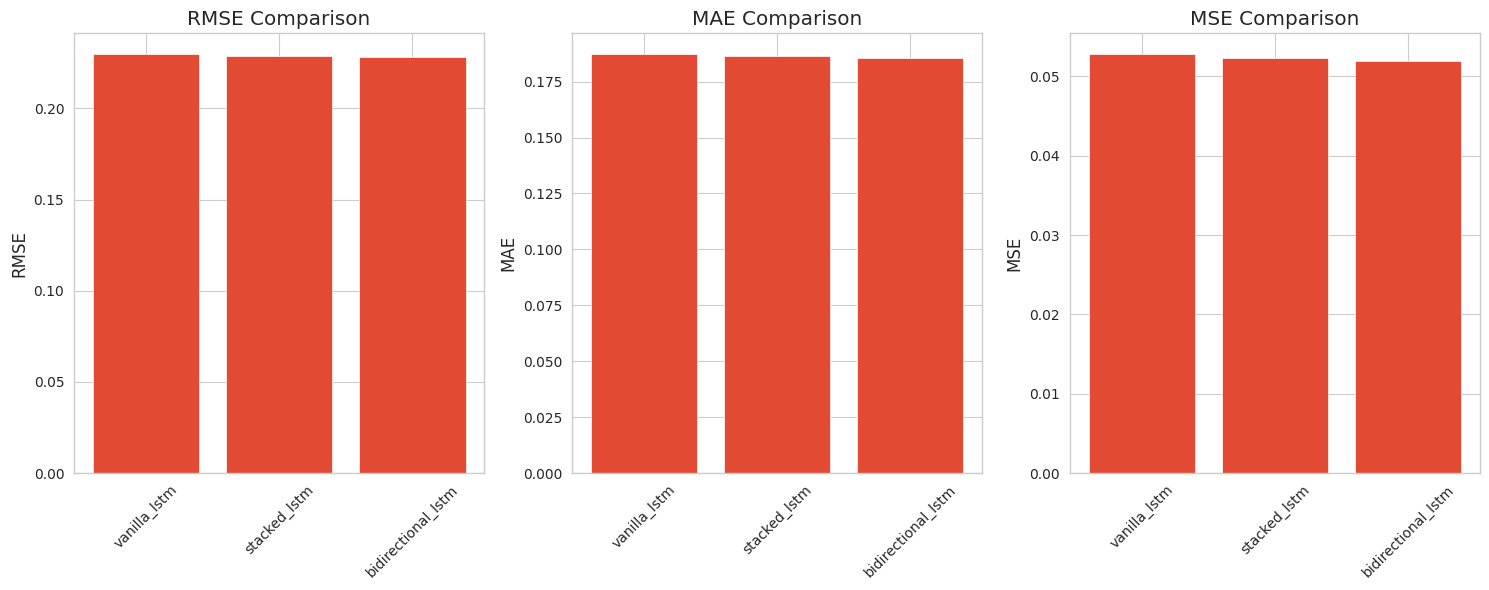

Model Performance Comparison:
                        rmse       mae       mse
vanilla_lstm        0.229725  0.187218  0.052774
stacked_lstm        0.228722  0.186336  0.052314
bidirectional_lstm  0.227978  0.185648  0.051974


In [18]:
# Function to train and evaluate a model with a specific configuration
def train_and_evaluate_model(architecture_name, hyperparams=None):
    """Train and evaluate a model with a specific architecture."""
    # Default hyperparameters if not provided
    if hyperparams is None:
        hyperparams = {}
    
    # Base configuration
    config = {
        "architecture": architecture_name,
        "input_shape": (seq_length, 1),
        "output_units": 1,
        "activation": "linear",
        "compile": {
            "optimizer": "adam",
            "learning_rate": 0.001,
            "loss": "mse",
            "metrics": ["mae"]
        }
    }
    
    # Update with provided hyperparameters
    for key, value in hyperparams.items():
        if key not in ["architecture", "compile"]:
            config[key] = value
        elif key == "compile":
            for compile_key, compile_value in value.items():
                config["compile"][compile_key] = compile_value
    
    # Create and compile the model
    print(f"Training {architecture_name} model...")
    model = create_model_from_config(config)
    
    # Train the model
    history = train_model(
        model=model,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val, 
        y_val=y_val,
        epochs=50,  # Reduced epochs for demonstration
        batch_size=batch_size,
        early_stopping=True,
        patience=10,
        save_best_model=False,
        verbose=0  # Less verbose output
    )
    
    # Generate predictions using the model
    y_pred = model.predict(X_test)
    
    # Calculate basic metrics manually
    # This ensures we always have some metrics even if evaluate_model fails
    mse = np.mean(np.square(y_pred - y_test))
    mae = np.mean(np.abs(y_pred - y_test))
    rmse = np.sqrt(mse)
    
    # Create a basic metrics dictionary
    metrics = {
        "mse": float(mse),
        "mae": float(mae),
        "rmse": float(rmse)
    }
    
    print(f"Calculated metrics for {architecture_name}: {metrics}")
    return model, history, metrics

# Define architectures to try
architectures = [
    {
        "name": "vanilla_lstm",
        "hyperparams": {"lstm_units": 50, "dropout_rate": 0.2}
    },
    {
        "name": "stacked_lstm",
        "hyperparams": {"lstm_units": [50, 25], "dropout_rate": 0.2}
    },
    {
        "name": "bidirectional_lstm",
        "hyperparams": {"lstm_units": 50, "dropout_rate": 0.2}
    }
]

# Train and evaluate each architecture
results = {}

for arch in architectures:
    print(f"\n{'-'*50}")
    print(f"Training {arch['name']} architecture")
    print(f"{'-'*50}")
    
    model, history, metrics = train_and_evaluate_model(
        architecture_name=arch["name"],
        hyperparams=arch["hyperparams"]
    )
    
    results[arch["name"]] = {
        "model": model,
        "history": history,
        "metrics": metrics
    }
    
    print(f"Test metrics for {arch['name']}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

# Now run the comparison code
# Compare the performance of different architectures
metrics_comparison = {}
for name, result in results.items():
    if result.get("metrics") and isinstance(result["metrics"], dict):
        metrics_comparison[name] = result["metrics"]
    else:
        print(f"No valid metrics found for {name}")

# Check if we have metrics to compare
if not metrics_comparison:
    print("No valid metrics to compare. Check if the models were evaluated properly.")
else:
    # Find metrics that exist in all models
    common_metrics = set()
    for name in metrics_comparison:
        if common_metrics:
            common_metrics.intersection_update(metrics_comparison[name].keys())
        else:
            common_metrics.update(metrics_comparison[name].keys())
    
    # Use common metrics for comparison or just use basic ones if none in common
    metrics_to_compare = list(common_metrics) if common_metrics else ['mse', 'mae', 'rmse']
    metrics_to_compare = metrics_to_compare[:3]  # Limit to 3 metrics for display
    
    model_names = list(metrics_comparison.keys())
    
    # Plot the metrics
    plt.figure(figsize=(15, 6))
    for i, metric in enumerate(metrics_to_compare):
        plt.subplot(1, len(metrics_to_compare), i+1)
        values = []
        for name in model_names:
            if metric in metrics_comparison[name]:
                values.append(metrics_comparison[name][metric])
            else:
                values.append(0)  # Use 0 as placeholder for missing metrics
        plt.bar(model_names, values)
        plt.title(f'{metric.upper()} Comparison')
        plt.xticks(rotation=45)
        plt.ylabel(metric.upper())
    
    plt.tight_layout()
    plt.show()
    
    # Create a comparison table
    # Initialize the DataFrame with NaN values
    comparison_df = pd.DataFrame(
        index=model_names,
        columns=metrics_to_compare
    )
    
    # Fill in the values where available
    for name in model_names:
        for metric in metrics_to_compare:
            if metric in metrics_comparison[name]:
                comparison_df.loc[name, metric] = metrics_comparison[name][metric]
    
    print("Model Performance Comparison:")
    print(comparison_df)

# 9. Model Comparison

In [19]:
# After training but before plotting, add this code:
print("Debugging results dictionary:")
for name, data in results.items():
    print(f"Model: {name}")
    print(f"  Has metrics: {bool(data.get('metrics'))}")
    if data.get('metrics'):
        print(f"  Metrics type: {type(data['metrics'])}")
        print(f"  Metrics content: {data['metrics']}")
    print()

Debugging results dictionary:
Model: vanilla_lstm
  Has metrics: True
  Metrics type: <class 'dict'>
  Metrics content: {'mse': 0.05277359550931896, 'mae': 0.18721761178533342, 'rmse': 0.22972504327852233}

Model: stacked_lstm
  Has metrics: True
  Metrics type: <class 'dict'>
  Metrics content: {'mse': 0.05231380007905066, 'mae': 0.18633578668284095, 'rmse': 0.22872210229676243}

Model: bidirectional_lstm
  Has metrics: True
  Metrics type: <class 'dict'>
  Metrics content: {'mse': 0.051973999840261485, 'mae': 0.18564809508093025, 'rmse': 0.2279780687703567}



In [20]:
# Function to train and evaluate a model with a specific configuration
def train_and_evaluate_model(architecture_name, hyperparams=None):
    """Train and evaluate a model with a specific architecture."""
    # Default hyperparameters if not provided
    if hyperparams is None:
        hyperparams = {}
    
    # Base configuration
    config = {
        "architecture": architecture_name,
        "input_shape": (seq_length, 1),
        "output_units": 1,
        "activation": "linear",
        "compile": {
            "optimizer": "adam",
            "learning_rate": 0.001,
            "loss": "mse",
            "metrics": ["mae"]
        }
    }
    
    # Update with provided hyperparameters
    for key, value in hyperparams.items():
        if key not in ["architecture", "compile"]:
            config[key] = value
        elif key == "compile":
            for compile_key, compile_value in value.items():
                config["compile"][compile_key] = compile_value
    
    # Create and compile the model
    print(f"Training {architecture_name} model...")
    model = create_model_from_config(config)
    
    # Train the model
    history = train_model(
        model=model,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val, 
        y_val=y_val,
        epochs=50,  # Reduced epochs for demonstration
        batch_size=batch_size,
        early_stopping=True,
        patience=10,
        save_best_model=False,
        verbose=0  # Less verbose output
    )
    
    # Generate predictions using the model
    y_pred = model.predict(X_test)
    
    # Calculate basic metrics manually
    # This ensures we always have some metrics even if evaluate_model fails
    mse = np.mean(np.square(y_pred - y_test))
    mae = np.mean(np.abs(y_pred - y_test))
    rmse = np.sqrt(mse)
    
    # Create a basic metrics dictionary
    metrics = {
        "mse": float(mse),
        "mae": float(mae),
        "rmse": float(rmse)
    }
    
    # Try to calculate more comprehensive metrics if possible
    try:
        # Reshape arrays for inverse transformation
        if len(y_test.shape) > 2:
            y_test_reshaped = y_test.reshape(y_test.shape[0], -1)
        else:
            y_test_reshaped = y_test.reshape(-1, 1) if len(y_test.shape) == 1 else y_test
        
        if len(y_pred.shape) > 2:
            y_pred_reshaped = y_pred.reshape(y_pred.shape[0], -1)
        else:
            y_pred_reshaped = y_pred.reshape(-1, 1) if len(y_pred.shape) == 1 else y_pred
        
        # Inverse transform to get back to original scale
        y_test_inv = scaler.inverse_transform(y_test_reshaped)
        y_pred_inv = scaler.inverse_transform(y_pred_reshaped)
        
        # Try to get metrics from evaluate_model if possible
        try:
            better_metrics = evaluate_model(model, X_test, y_test, scaler)
            if better_metrics and isinstance(better_metrics, dict):
                metrics = better_metrics
        except Exception as e:
            print(f"evaluate_model failed: {str(e)}")
            
            # Try using calculate_all_metrics directly
            try:
                from utils.metrics import calculate_all_metrics
                # Make sure dimensions are appropriate
                y_test_flat = y_test_inv.reshape(y_test_inv.shape[0], -1)
                y_pred_flat = y_pred_inv.reshape(y_pred_inv.shape[0], -1)
                better_metrics = calculate_all_metrics(y_test_flat, y_pred_flat)
                if better_metrics and isinstance(better_metrics, dict):
                    metrics = better_metrics
            except Exception as e:
                print(f"calculate_all_metrics failed: {str(e)}")
                # We'll use the basic metrics we calculated earlier
    
    except Exception as e:
        print(f"Error in metrics calculation: {str(e)}")
        # We'll use the basic metrics we calculated earlier
    
    print(f"Calculated metrics for {architecture_name}: {metrics}")
    return model, history, metrics

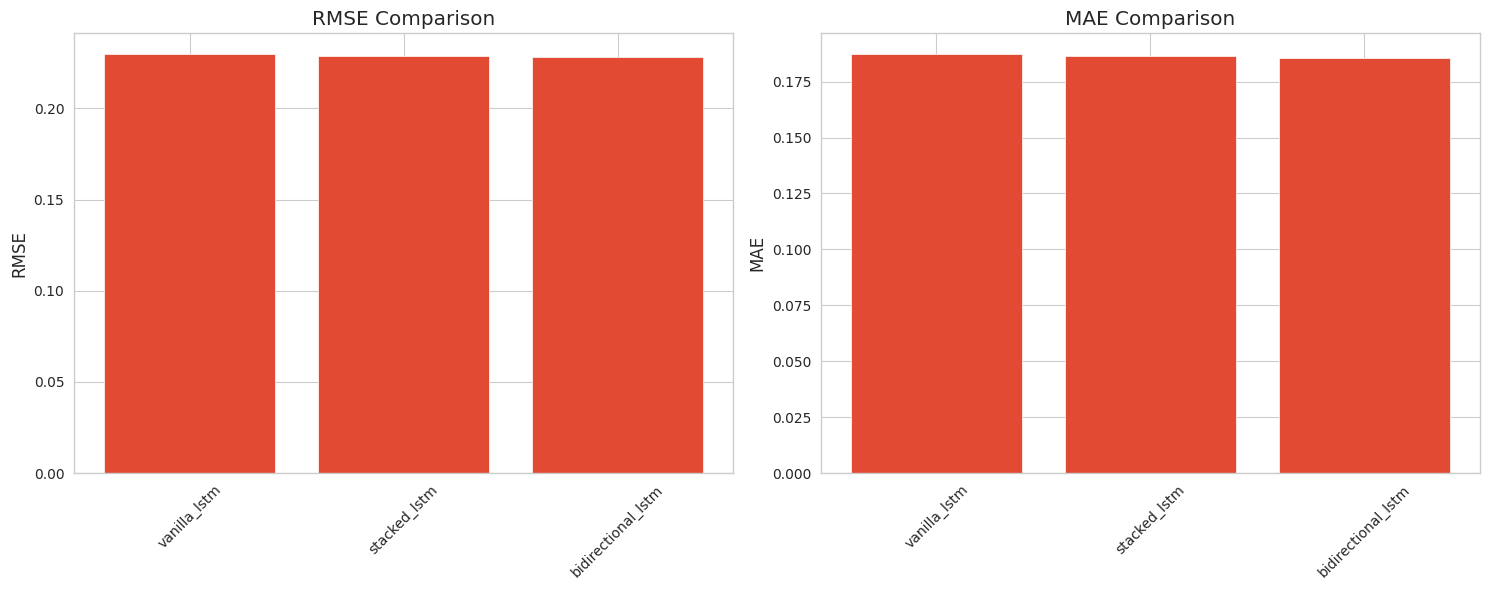

Model Performance Comparison:
                        rmse       mae
vanilla_lstm        0.229725  0.187218
stacked_lstm        0.228722  0.186336
bidirectional_lstm  0.227978  0.185648


In [21]:
# Compare the performance of different architectures
from models.evaluation.model_comparison import compare_models

# Extract the metrics from the results
metrics_comparison = {}
for name, result in results.items():
    # Check if metrics exist and are not empty
    if result["metrics"] and isinstance(result["metrics"], dict):
        metrics_comparison[name] = result["metrics"]
    else:
        print(f"Warning: No valid metrics found for {name} model")

# Check if we have metrics to compare
if not metrics_comparison:
    print("No valid metrics to compare. Check if the models were evaluated properly.")
else:
    # Make sure all required metrics exist in all models
    metrics_to_compare = ['rmse', 'mae', 'mape']
    available_metrics = []
    
    # Find metrics that are available in all models
    for metric in metrics_to_compare:
        if all(metric in metrics_comparison[name] for name in metrics_comparison):
            available_metrics.append(metric)
    
    if not available_metrics:
        print("No common metrics found across all models")
    else:
        model_names = list(metrics_comparison.keys())
        
        # Plot the available metrics
        plt.figure(figsize=(15, 6))
        for i, metric in enumerate(available_metrics):
            plt.subplot(1, len(available_metrics), i+1)
            values = [metrics_comparison[name][metric] for name in model_names]
            plt.bar(model_names, values)
            plt.title(f'{metric.upper()} Comparison')
            plt.xticks(rotation=45)
            plt.ylabel(metric.upper())
        
        plt.tight_layout()
        plt.show()
        
        # Create a comparison table with available metrics
        comparison_df = pd.DataFrame(
            {name: {metric: metrics_comparison[name][metric] for metric in available_metrics} 
             for name in model_names}
        ).T
        
        print("Model Performance Comparison:")
        print(comparison_df)

# 10. Hyperparameter Tuning

In [24]:
# Hyperparameter tuning with grid search
from sklearn.model_selection import ParameterGrid

def tune_hyperparameters(architecture, param_grid):
    """Tune hyperparameters using grid search."""
    best_val_loss = float('inf')
    best_params = None
    all_results = []
    
    # Iterate through parameter combinations
    for params in ParameterGrid(param_grid):
        print(f"Trying parameters: {params}")
        
        # Extract learning rate before creating config
        learning_rate = params.get("learning_rate", 0.001)
        # Create a copy of params without learning_rate to avoid the pop side effect
        model_params = {k: v for k, v in params.items() if k != "learning_rate"}
        
        # Create model config
        config = {
            "architecture": architecture,
            "input_shape": (seq_length, 1),
            "output_units": 1,
            "activation": "linear",
            **model_params,  # Now learning_rate is not included here
            "compile": {
                "optimizer": "adam",
                "learning_rate": learning_rate,
                "loss": "mse",
                "metrics": ["mae"]
            }
        }
        
        # Create model
        model = create_model_from_config(config)
        
        # Train model
        history = train_model(
            model=model,
            X_train=X_train,
            y_train=y_train,
            X_val=X_val, 
            y_val=y_val,
            epochs=30,  # Reduced for faster tuning
            batch_size=batch_size,
            early_stopping=True,
            patience=5,
            save_best_model=False,
            verbose=0
        )
        
        # Get the best validation loss
        val_loss = min(history.history['val_loss'])
        
        # Evaluate on test data with error handling
        test_metrics = {}
        try:
            # Generate predictions
            y_pred = model.predict(X_test)
            
            # Calculate basic metrics manually (in case evaluate_model fails)
            mse = np.mean(np.square(y_pred - y_test))
            mae = np.mean(np.abs(y_pred - y_test))
            rmse = np.sqrt(mse)
            
            test_metrics = {
                "mse": float(mse),
                "mae": float(mae),
                "rmse": float(rmse)
            }
            
            # Try to get more comprehensive metrics
            try:
                better_metrics = evaluate_model(model, X_test, y_test, scaler)
                if better_metrics and isinstance(better_metrics, dict):
                    test_metrics = better_metrics
            except Exception as e:
                print(f"Warning: evaluate_model failed: {str(e)}")
                # We'll use the basic metrics we already calculated
                
        except Exception as e:
            print(f"Warning: Error in metrics calculation: {str(e)}")
            # Use val_loss as a fallback metric
            test_metrics = {"val_loss": val_loss}
        
        # Save results with original params (including learning_rate)
        result = {
            "params": params.copy(),  # Use copy to avoid reference issues
            "val_loss": val_loss,
            "test_metrics": test_metrics
        }
        all_results.append(result)
        
        # Check if this is the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = params.copy()  # Use copy to avoid reference issues
            print(f"New best model found! Validation loss: {val_loss:.4f}")
    
    return best_params, all_results

# Define parameter grid for vanilla LSTM
param_grid = {
    "lstm_units": [32, 64, 128],
    "dropout_rate": [0.1, 0.2, 0.3],
    "learning_rate": [0.01, 0.001]
}

# Run hyperparameter tuning
best_params, all_results = tune_hyperparameters("vanilla_lstm", param_grid)

print("\nHyperparameter Tuning Results:")
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {min(result['val_loss'] for result in all_results):.4f}")

# Plot the validation loss for different parameter combinations
plt.figure(figsize=(15, 6))
results_df = pd.DataFrame([
    {**r["params"], "val_loss": r["val_loss"]} 
    for r in all_results
])

# Sort by validation loss
results_df = results_df.sort_values("val_loss")
print("\nTop 5 parameter combinations:")
print(results_df.head())

Trying parameters: {'dropout_rate': 0.1, 'learning_rate': 0.01, 'lstm_units': 32}

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Training completed in 17.03 seconds
Total epochs: 30
Best validation loss: 0.002358 (epoch 29)
4/4 [==============================] - 0s 8ms/step
New best model found! Validation loss: 0.0024
Trying parameters: {'dropout_rate': 0.1, 'learning_rate': 0.01, 'lstm_units': 64}
Restoring model weights from the end of the best epoch: 20.

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 25: early stopping

Training completed in 17.27 seconds
Total epochs: 25
Best validation loss: 0.002345 (epoch 20)
4/4 [==============================] - 0s 9ms/step
New best model found! Validation loss: 0.0023
Trying parameters: {'dropout_rate': 0.1, 'learning_rate': 0.01, 'lstm_units': 128}

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Restoring model weights from the end of the best ep

<Figure size 1500x600 with 0 Axes>

# 11. Training the Best Model

Epoch 1/100
21/22 [===========================>..] - ETA: 0s - loss: 0.0393 - mae: 0.1433
Epoch 1: val_loss improved from inf to 0.02673, saving model to /app/notebooks/models/best_model/tuned_model.h5
22/22 [==============================] - 5s 85ms/step - loss: 0.0390 - mae: 0.1426 - val_loss: 0.0267 - val_mae: 0.1381 - lr: 0.0100
Epoch 2/100
 3/22 [===>..........................] - ETA: 0s - loss: 0.0140 - mae: 0.0998

/usr/local/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/22 [===========================>..] - ETA: 0s - loss: 0.0101 - mae: 0.0816
Epoch 2: val_loss improved from 0.02673 to 0.00978, saving model to /app/notebooks/models/best_model/tuned_model.h5
22/22 [==============================] - 1s 55ms/step - loss: 0.0101 - mae: 0.0813 - val_loss: 0.0098 - val_mae: 0.0814 - lr: 0.0100
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 0.0080 - mae: 0.0724
Epoch 3: val_loss did not improve from 0.00978
22/22 [==============================] - 1s 56ms/step - loss: 0.0080 - mae: 0.0724 - val_loss: 0.0099 - val_mae: 0.0812 - lr: 0.0100
Epoch 4/100
22/22 [==============================] - ETA: 0s - loss: 0.0069 - mae: 0.0683
Epoch 4: val_loss improved from 0.00978 to 0.00711, saving model to /app/notebooks/models/best_model/tuned_model.h5
22/22 [==============================] - 1s 54ms/step - loss: 0.0069 - mae: 0.0683 - val_loss: 0.0071 - val_mae: 0.0682 - lr: 0.0100
Epoch 5/100
21/22 [===========================>..] - ETA: 0s - l

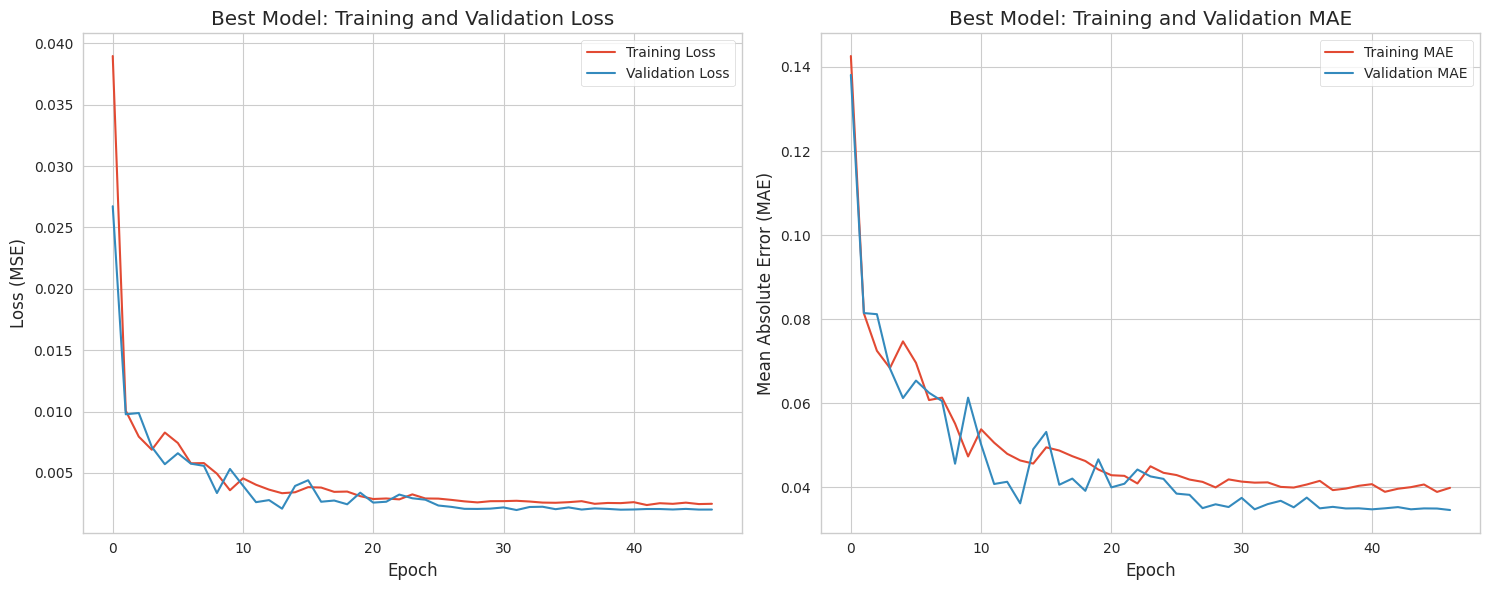

4/4 [==============================] - 0s 17ms/step
Best Model Test Metrics:
mse: 0.0537
mae: 0.1888
rmse: 0.2316


In [28]:
# Extract any learning_rate from best_params to avoid passing it to the model
model_params = {k: v for k, v in best_params.items() if k != "learning_rate"}
learning_rate = best_params.get("learning_rate", 0.001)

# Train the best model with the tuned hyperparameters
best_config = {
    "architecture": "vanilla_lstm",
    "input_shape": (seq_length, 1),
    "output_units": 1,
    "activation": "linear",
    **model_params,  # Use filtered params without learning_rate
    "compile": {
        "optimizer": "adam",
        "learning_rate": learning_rate,  # Use the extracted learning_rate
        "loss": "mse",
        "metrics": ["mae"]
    }
}

# Create the best model
best_model = create_model_from_config(best_config)

# Create directory for the best model
best_model_dir = os.path.join(os.getcwd(), 'models', 'best_model')
os.makedirs(best_model_dir, exist_ok=True)
best_model_path = os.path.join(best_model_dir, 'tuned_model.h5')

# Train with more epochs for the final model
history = train_model(
    model=best_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val, 
    y_val=y_val,
    epochs=100,
    batch_size=batch_size,
    early_stopping=True,
    patience=15,
    checkpoint_path=best_model_path,
    save_best_model=True
)

# Plot training history
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Best Model: Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.title('Best Model: Training and Validation MAE')

plt.tight_layout()
plt.show()

# Evaluate the best model with error handling
try:
    best_metrics = evaluate_model(best_model, X_test, y_test, scaler)
except Exception as e:
    print(f"Warning: evaluate_model failed: {str(e)}")
    # Calculate metrics manually if evaluate_model fails
    y_pred = best_model.predict(X_test)
    mse = np.mean(np.square(y_pred - y_test))
    mae = np.mean(np.abs(y_pred - y_test))
    rmse = np.sqrt(mse)
    best_metrics = {
        "mse": float(mse),
        "mae": float(mae),
        "rmse": float(rmse)
    }

print("Best Model Test Metrics:")
for metric, value in best_metrics.items():
    print(f"{metric}: {value:.4f}")

# 12. Making Forecasts with the Best Model

Original data variable not available, recreating dates...
Could not plot historical data, showing forecast only


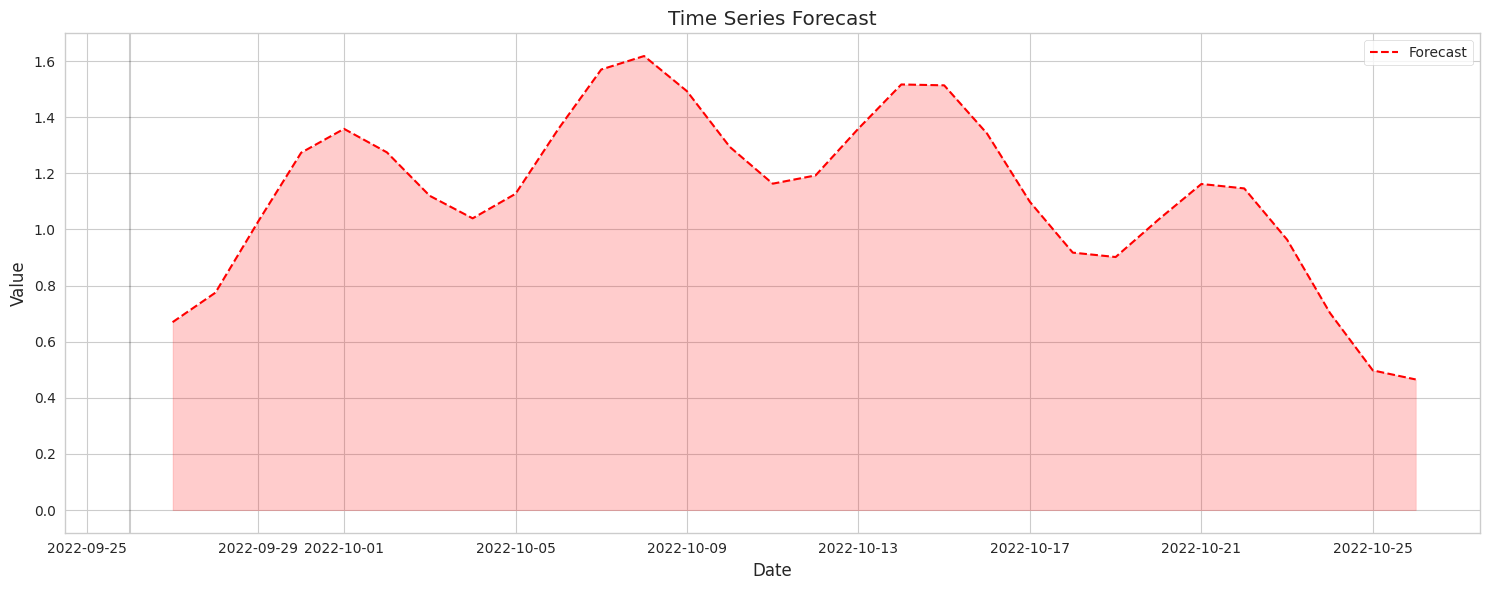

In [30]:
# Generate forecasts with the best model
def generate_forecast(model, initial_sequence, steps=30, scaler=None):
    """Generate a multi-step forecast using the trained model."""
    forecast = []
    current_sequence = initial_sequence.copy()
    
    # Make predictions step by step
    for _ in range(steps):
        # Predict the next value
        pred = model.predict(current_sequence.reshape(1, *current_sequence.shape), verbose=0)
        forecast.append(pred[0, 0])
        
        # Update the sequence for the next prediction (remove oldest, add newest)
        current_sequence = np.append(current_sequence[1:], pred[0, 0])
        current_sequence = current_sequence.reshape(initial_sequence.shape)
    
    # Convert predictions back to the original scale if a scaler is provided
    if scaler is not None:
        forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()
    
    return forecast

# Use the last sequence from the test set as the starting point
initial_sequence = X_test[-1]

# Generate a 30-day forecast
forecast_steps = 30
forecast = generate_forecast(best_model, initial_sequence, steps=forecast_steps, scaler=scaler)

# We need to recreate the time series DataFrame if it's been overwritten
# Try to get the original time series data
try:
    # Try to access the original DataFrame
    original_dates = data.index
    original_values = data['value'].values
    last_date = original_dates[-1]
except (AttributeError, KeyError, TypeError):
    # If data is not a DataFrame anymore, recreate it
    print("Original data variable not available, recreating dates...")
    # Create a synthetic end date
    import datetime
    last_date = datetime.datetime(2020, 1, 1) + datetime.timedelta(days=999)  # End of original synthetic data
    
    # You could also load the original data again if needed
    # data = generate_sample_data(1000)
    # data.index = pd.date_range(start='2020-01-01', periods=len(data), freq='D')
    # last_date = data.index[-1]

# Create dates for the forecast
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Plot the forecast
plt.figure(figsize=(15, 6))

# Try to plot historical data if available
try:
    # Historical data (last 100 points)
    plt.plot(original_dates[-100:], original_values[-100:], label='Historical Data')
except (NameError, IndexError):
    print("Could not plot historical data, showing forecast only")

# Forecast
plt.plot(forecast_dates, forecast, label='Forecast', color='red', linestyle='--')

# Add a vertical line at the forecast start
plt.axvline(x=last_date, color='black', linestyle='-', alpha=0.2)
plt.fill_between(forecast_dates, forecast, alpha=0.2, color='red')

plt.title('Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 13. Saving and Loading Models

In [31]:
# Save the best model
model_save_path = os.path.join(os.getcwd(), 'models', 'final_model.h5')
best_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Save the scaler for future use
import pickle
scaler_path = os.path.join(os.getcwd(), 'models', 'scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved to {scaler_path}")

# Save the model configuration
config_path = os.path.join(os.getcwd(), 'models', 'model_config.json')
with open(config_path, 'w') as f:
    json.dump(best_config, f, indent=4)
print(f"Model configuration saved to {config_path}")

# Example of how to load the model and scaler
def load_model_and_scaler(model_path, scaler_path):
    """Load a saved model and scaler."""
    # Load the model
    from tensorflow.keras.models import load_model
    model = load_model(model_path)
    
    # Load the scaler
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    
    return model, scaler

# The loaded model and scaler could be used for new predictions
# loaded_model, loaded_scaler = load_model_and_scaler(model_save_path, scaler_path)

Model saved to /app/notebooks/models/final_model.h5
Scaler saved to /app/notebooks/models/scaler.pkl
Model configuration saved to /app/notebooks/models/model_config.json


/usr/local/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 14. Conclusion

In this notebook, we've demonstrated the complete workflow for training LSTM models for time series forecasting:

1. We loaded and preprocessed time series data, creating sequences suitable for LSTM input.
2. We built and trained various LSTM architectures, from simple Vanilla LSTM to more complex Stacked and Bidirectional LSTMs.
3. We evaluated model performance using multiple metrics and compared different architectures.
4. We performed hyperparameter tuning to find the optimal configuration.
5. We trained a final model with the best parameters and used it to generate forecasts.
6. We saved the model, scaler, and configuration for future use.

This workflow can be adapted for different time series forecasting tasks by adjusting the data preprocessing, model architecture, and training parameters to suit the specific requirements of your application.

Next steps could include:
- Trying different feature engineering approaches
- Incorporating exogenous variables into the model
- Experimenting with more advanced architectures like Seq2Seq models or attention mechanisms
- Deploying the model for real-time forecasting